## Assignment 3
### Josh Broomberg

This assignment focuses on how Principal Component Analysis and Linear Discriminant Analysis can be applied to feature-rich data into to make it tractable for linear classifiers. In this case, the data used was a sample of 1200 images of mens' and women's clothing with a classifier trained to identify he gender of the clothing in an image. Neither method showed particularly good in absolute terms but the results from each did demonstrate many of the advantages, and pitfals, of the respective approaches. 

Three notes. First, Classification was done primarily with a Support Vector Classification (SVC) implementation of an SVM. Although this model was compared against logistic regression using cross-validation, very little difference was noticed. This is discussed more in the analysis below. Second, all results below are reported with a randomly sampled training set of 960 observations (80% of 1200 total observations). The remaining 240 observations were reserved for testting. Finally, he primary metric used for evluation is accuracy. This is because there is no particular disparity between false negatives (classifying a male clothing item

### Analysis of Results

Three analyses are presented. First, the results of classification on raw, untransformed data. Second, analysis on classification after PCA. Finally, the results of classification after LDA. A hydrid of PCA and LDA is discussed in the third section.

**1) Raw Classification:**

  A Linear SVC was applied directly to the untransformed training set. The training process took just under 2 minutes, which is to be expected (even with the small training set) given the number of features in each observation. The resultant model had 100% accuracy on the training data. This demonstratates a classic problem when fitting linear models to high dimension data sets where the number of observations is much less than the number of feaures. The model can essentially use one coefficient to perfectly fit to each training observation - resulting in severe overfit. 
    
  Regularization to prevent this overfit was not explored because it was unlikely to be able to counter the observed effect. Rather, an attempt was made to build a bagged model - an ensemble of 10 SVC models each trained on one tenth of the data set. Theoretically, this would prevent any given model from overfitting the entire data set. The individual models then vote on a final classification by majority. This method proved ineffective - training accuracy was still 100%. 
    
  The test accuracy for the single SVC was 66%. This is a decent result - certainly better than chance. In this case, given the evidence of an overfit in training, I would put this down largely to fluke or to the model using some very clear signals in the data to get some results correct. 


** 2) PCA: **

  PCA is an *unsupervised* dimensionality reduction. It's usefulness in this case is captured by that simple description: it is used to reduce the dimensionality such that a linear model no longer badly overfits the data. In this case, we first ran open-ended PCA on the dataset (with no restriction on the number of components to return). This showed that the first ~25 components provide most of the explanatory power - explaining about 65% of the feature variance (see Figure 1 below). This indicates that, to some extent, the features (pixels) in the data are correlated with each other. This is to be expected where all images have a roughly centered figure made of continuous lines. When PCA was used with the model, CV was used to find an optimal number of components (finding the optimal point between enough components to capture relevent information and the decrease in accuracy from to many features in the linear model). The CV revealed that around 200 components was best.
  
  When trained, the PCA + Linear classifier showed very little improvement over the raw classifier. In fact, the accruacy was 1% lower at 65% on the test data. While this was somewhat surprising it is also understandable. First, note two positive results. One, that the training time for the model after PCA was ~8.5 seconds around 15x faster than he raw data (for essentially the same result). Two, that the training accuracy was 78% meaning PCA did prevent to marked overfitting from before (although after CV optimization, the training accuracy did increase to 99% it is unclear if this was the effect of the PCA or the tuning of model parameters). With these in mind, we can explore why PCA may not have improved the result. 
  
  First, PCA exploits feature-level correlation. But, in order to accurate represent the *information* from the features in lower dimensional space, the correlation between features must be linear (such that the information is captured by the new linear 'directions'. It is highly likely that the contiguous, curved shapes represenetd by the pixels in the raw images are correlated non-linearly. This makes PCA perform poorly. Second, PCA is unsupervised. Principle Directions are chosen to maximize variance along the directio (under the assumption that this direction must convey the most 'information'. However, if this maximization is not done subject to the class information it is possible that the result lower dimensional representation of the data will have the data points from each class very close together. Separability is completely ignored in this method. This problem is evident in the reconstructed images in Figure 2 which show the image representation of the top components and the images most representative of the component (with tthe highest associated projection value). Often, clothes from the same gender are on opposite ends of the same components' 'spectrum' indicating separation is occuring within class in some dimensions. PCA was unable to detect key separation dimensions - as one would expect - creating data that was hard to later classify.

 
3) LDA:

  LDA is *supervised* dimensionality reduction. It maximizes separability of the classes under some very strict assumptions on the underlying data. In this case, despite the aparent advantage of this method, LDA also showed very little improvement over the raw data. In fact, accruacy was slightly lower at 64% in test (and 93% on training). 
  
  Firstly, LDA relies on the invertability of the classes' covariance matrix. Where the number of observations is less than the number of features, this will not be the case because the data 'vectors' will not span the full feature space. This means the data must first be projected down onto a space that is spanned by it before LDA is performed. This is done automatically by Scikit using a "thin SVD" (as mentioned in Barber) however, the effect of this transformation on the efficacy of LDA is indeterminate. Research shows that in these conditions, LDA may end up overfitting the data because the covariance matrix will be near singular. I believe a valid way to think about this is that the proposed variance for each class will be "large" meaning that LDA can place the means far apart, creating 'separation' without decreasing the probability of observing this configuration (because the distributions are 'wide'). To some extent, this is confirmed by the results with high train accuracy and low test accuracy. Ultimately, the issue is that LDA relies on an accurate estimation of covariance which is hard when the number of features is >> than the number of observations. See [here](https://stats.stackexchange.com/questions/106121/does-it-make-sense-to-combine-pca-and-lda) for the research on this. A more fundamental problem could be with the assumption that the data was generated by a multivariate Gaussian. It is unclear whether his actually holds in this case - which could explain he poor results. 
  
  Two attempts were made to address the issue of high feature to observation ratio. First, the shrinkage parameter was tested. This 'shrinks' the artificially wide covariance. No results were obtained for this method because the training proved computationally exhaustive with any reasonable amount of data (>2 hours on AWS machine with 16 cores in parallel...). Second, PCA was run on the data before LDA. This showed the best result of any trial with test accruacy of 69%. Further, it reduced the train accuracy to 73%. This indicates mitigation of the overfitting and promising increase in accuracy. No work was done to optimize this pipeline, so the hope is that further work could improve these resuls further. Again, this serves to confirm - to some extent - the hypothesized flaws analuzed above.
  
** Recomendations **

It appears that some hybrid of the two dimension reductions is most promising. Further work is needed to verify this hypothesis. The analysis revealed no difference between SVC and Logistic classifiers but, again, further work is needed to verify this claim.


In [1]:
from PIL import Image
import PIL.ImageOps    
from glob import glob

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import numpy as np

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV

from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier

from sklearn.pipeline import Pipeline
from sklearn.externals.joblib import Memory
from tempfile import mkdtemp
from shutil import rmtree

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

SEED = 5
np.random.seed(seed=SEED)

import warnings
warnings.filterwarnings("ignore")

### Process Images

Resize the images, flatten each into a pixel vector, and globally-center the pixel vector by removing the mean.

In [2]:
NUM_IMAGES_PER_GENDER = 600
IMAGE_SIZE = (120, 150)

male_images = np.random.choice(glob('clean_images/Male/*/*'),
                        NUM_IMAGES_PER_GENDER, replace=False)
female_images = np.random.choice(glob('clean_images/Female/*/*'),
                     NUM_IMAGES_PER_GENDER, replace=False)

images = []

def read_image(image_file):
    with open(image_file, 'r+b') as f:
        with Image.open(f) as image:
            resized = image.resize(IMAGE_SIZE)
            return np.array(resized).flatten()

# Process images, creating labelled pixel vectors
# which will be useful in a classifier. This single data structure
# is for convinience.
images = [(read_image(path), 1, path) for path in male_images] +\
    [(read_image(path), 0, path) for path in female_images]

# Separate into image data and labels
raw_image_data = np.array([image[0] for image in images])
class_data = np.array([image[1] for image in images]) # useful for LDA later.

# Centering each pixel via the global 
# mean for that pixel.
global_pixel_means = np.mean(raw_image_data, axis=0) 
image_data = raw_image_data - global_pixel_means

print("Data shape: {}".format(image_data.shape))

Data shape: (1200, 54000)


In [3]:
image_data_train, image_data_test, y_train, y_test = train_test_split(
    image_data, class_data, test_size=0.2, random_state=SEED, stratify=class_data)

In [4]:
image_data_train.shape

(960, 54000)

#### Util Functions

In [5]:
def print_clf_report(mdl, X, y):
    predictions = mdl.predict(X)
    print("Accuracy: {}".format(accuracy_score(predictions, y)))
    print(classification_report(predictions, y))

In [6]:
# Normalize a pixel vector and return
# an image. This code is from:
# https://github.com/joelgrus/shirts/blob/master/visuals.py#L55
def image_from_component_values(pixel_arr):
    """takes one of the principal components and turns it into an image"""
    hi = max(pixel_arr)
    lo = min(pixel_arr)
    n = int(len(pixel_arr) / 3)
    divisor = hi - lo
    if divisor == 0:
        divisor = 1
    
    def rescale(x):
        return int(255 * (x - lo) / divisor)
    
    d = [(rescale(pixel_arr[3 * i]),
          rescale(pixel_arr[3 * i + 1]),
          rescale(pixel_arr[3 * i + 2])) for i in range(n)]
    im = Image.new('RGB',IMAGE_SIZE)
    im.putdata(d)
    return im

## 1. Classification without Compression

First, run an SVC classifier without any dimension reduction.

### Single CLF

In [34]:
%%time
svc_raw = LinearSVC(random_state=SEED)
svc_raw.fit(image_data_train, y_train)

CPU times: user 1min 53s, sys: 474 ms, total: 1min 54s
Wall time: 1min 54s


In [8]:
print_clf_report(svc_raw, image_data_train, y_train)

Accuracy: 1.0
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       480
          1       1.00      1.00      1.00       480

avg / total       1.00      1.00      1.00       960



In [9]:
print_clf_report(svc_raw, image_data_test, y_test)

Accuracy: 0.6583333333333333
             precision    recall  f1-score   support

          0       0.68      0.65      0.67       126
          1       0.63      0.67      0.65       114

avg / total       0.66      0.66      0.66       240



### Bagged CLF

In [27]:
run = True

if run:
    n_estimators = 10

    svc_raw_bagged = OneVsRestClassifier(
        BaggingClassifier(LinearSVC(random_state=SEED),
                          max_samples=1.0/n_estimators,
                          n_estimators=n_estimators,
                          n_jobs=-1))
    svc_raw_bagged.fit(image_data_train, y_train)

    print_clf_report(svc_raw_bagged, image_data_train, y_train)
    print_clf_report(svc_raw_bagged, image_data_test, y_test)

Accuracy: 1.0
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       480
          1       1.00      1.00      1.00       480

avg / total       1.00      1.00      1.00       960

Accuracy: 0.6583333333333333
             precision    recall  f1-score   support

          0       0.68      0.65      0.67       126
          1       0.63      0.67      0.65       114

avg / total       0.66      0.66      0.66       240



## 2. PCA

### Run PCA without Component Constraint

First, run the PCA without a specified number of components. This is useful for exploring how many components we really need.

From the plot, it looks like the first 12 components do most of the explaining. After this, we get a very small (and roughly constant) from each component. However, these 12 don't explain much in absolute terms (~0.6). This indicates our data is not easily compressible, which is somewhat natural given how rudementry the cleaning was.

In [11]:
pca = PCA(whiten=True, copy=True, random_state=SEED)
pca.fit(image_data_train)
differences = np.ediff1d(pca.explained_variance_ratio_)
summed = np.cumsum(pca.explained_variance_ratio_)

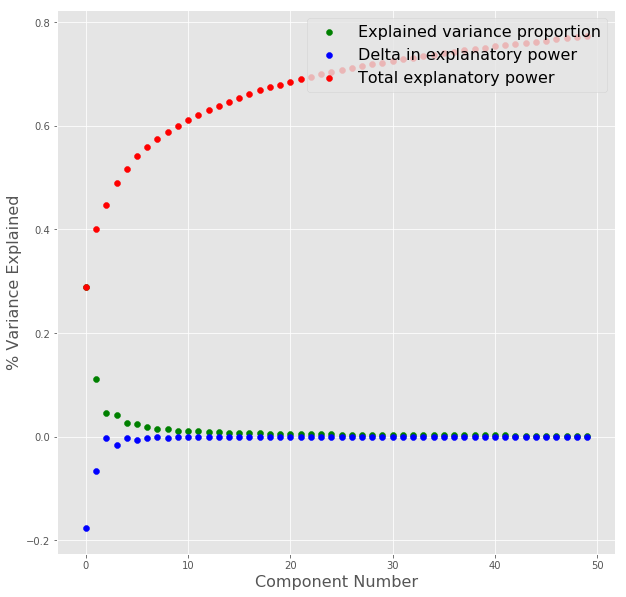

[0.28851802 0.11199589 0.04587631 0.04269874 0.02710445 0.02495263
 0.01830298 0.0149874  0.01394528 0.01179754 0.01055206 0.01012124
 0.00932584 0.00856125 0.00803053 0.00765229 0.00755447 0.00654866
 0.00575183 0.00553816]


In [12]:
plt.figure(figsize=(10, 10))
plot_num = 50

plt.scatter(
    list(range(plot_num)), pca.explained_variance_ratio_[:plot_num], 
    color='green', label='Explained variance proportion')

plt.scatter(list(range(plot_num)), differences[:plot_num], 
    color='blue', label='Delta in explanatory power')

plt.scatter(list(range(plot_num)), summed[:plot_num], 
    color='red', label='Total explanatory power')

plt.legend(loc=1, fontsize=16)
plt.xlabel(r'Component Number', size=16)
plt.ylabel(r'% Variance Explained', size=16)
plt.show()

print(pca.explained_variance_ratio_[:20])

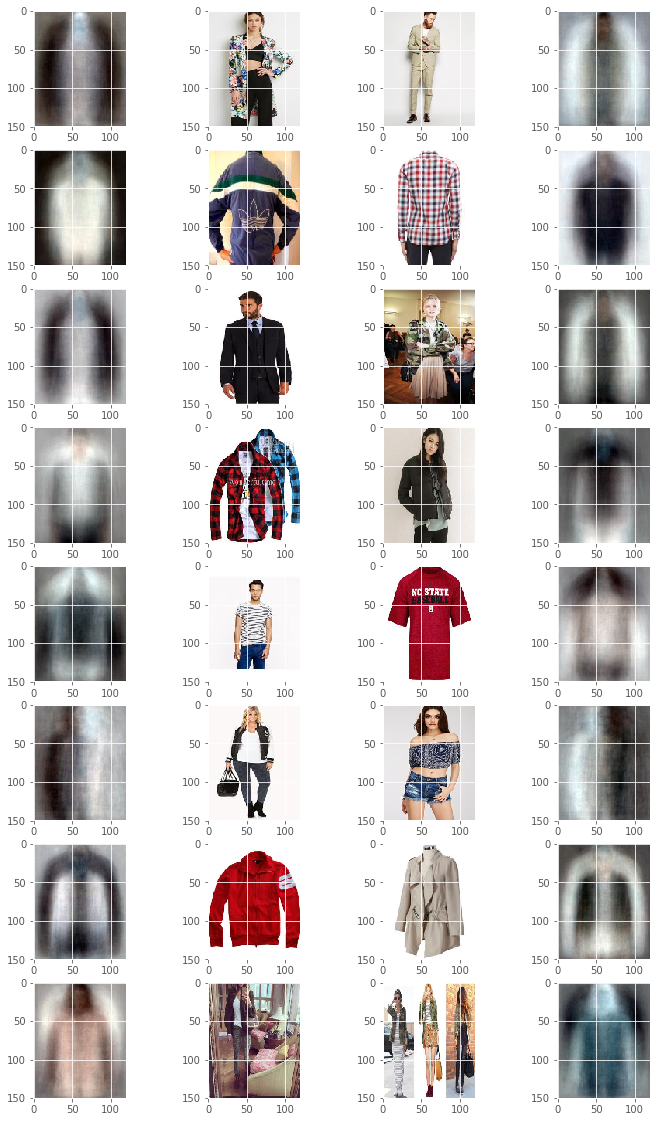

In [13]:
compressed_image_data_train = pca.transform(image_data_train)
uncompressed_image_data_train = pca.inverse_transform(compressed_image_data_train)

fig=plt.figure(figsize=(12, 20))
columns = 4
rows = 8
for i in range(1, columns*rows + 1, columns):
    component_id = int(i/columns)
    eigen_image = image_from_component_values(pca.components_[component_id])
    inverted_egein_image = PIL.ImageOps.invert(eigen_image)
    
    most_similar_id = (np.argmax(compressed_image_data_train[:, component_id]))
    most_dissimilar_id = (np.argmin(compressed_image_data_train[:, component_id]))

    
    fig.add_subplot(rows, columns, i)
    plt.imshow(eigen_image)
    
    fig.add_subplot(rows, columns, i+1)
    similar_image = plt.imshow(
        raw_image_data[most_similar_id, :].reshape(IMAGE_SIZE[1], IMAGE_SIZE[0], 3))
    
    fig.add_subplot(rows, columns, i+2)
    similar_image = plt.imshow(
        raw_image_data[most_dissimilar_id, :].reshape(IMAGE_SIZE[1], IMAGE_SIZE[0], 3))

    
    fig.add_subplot(rows, columns, i+3)
    plt.imshow(inverted_egein_image)
    
plt.show()

# Light to dark center
# Black vs white closes
# Light to dark top to bottom
# Light dark left to right
# light sleeves vs dark sleeves
# red vs blue
# dark-light rings
# dark vs light pocket area

### Use Manual PCA with SVC

First, we set the n_components to 15 and run an SVC classifier.

In [14]:
pca_prod = PCA(n_components=200, whiten=True, copy=True, random_state=SEED)
pca_prod.fit(image_data_train)

PCA(copy=True, iterated_power='auto', n_components=200, random_state=5,
  svd_solver='auto', tol=0.0, whiten=True)

Additionally, get the transformed (compressed) data set.

In [15]:
compressed_image_data_train = pca_prod.transform(image_data_train)
compressed_image_data_test = pca_prod.transform(image_data_test)

In [16]:
svc_pca = LinearSVC(random_state=SEED)
svc_pca.fit(compressed_image_data_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=5, tol=0.0001,
     verbose=0)

In [17]:
print_clf_report(svc_pca, compressed_image_data_train, y_train)

Accuracy: 0.784375
             precision    recall  f1-score   support

          0       0.80      0.78      0.79       491
          1       0.77      0.79      0.78       469

avg / total       0.78      0.78      0.78       960



In [18]:
print_clf_report(svc_pca, compressed_image_data_test, y_test)

Accuracy: 0.6666666666666666
             precision    recall  f1-score   support

          0       0.70      0.66      0.68       128
          1       0.63      0.68      0.66       112

avg / total       0.67      0.67      0.67       240



### PCA and SVC Optimization

Create a pipeline and use grid search to explore both optimal PCA and optimal SVC settings

In [19]:
pca_pipe = Pipeline(
    [
        ('reduce_dim', PCA()),
        ('classify', LinearSVC(fit_intercept=False, random_state=SEED))
    ])

N_FEATURES_OPTIONS = [100, 200, 400, 450, 500, 550]
C_OPTIONS = [0.1, 1, 10, 100, 200]
param_grid = [
    {
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'classify__C': C_OPTIONS
    },
]


pca_grid = GridSearchCV(pca_pipe, cv=3, n_jobs=-1, param_grid=param_grid, verbose=1)
pca_grid.fit(image_data_train, y_train)

print(pca_grid.best_params_, pca_grid.best_score_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  5.0min finished


{'classify__C': 1, 'reduce_dim__n_components': 500} 0.6385416666666667


In [33]:
%%time
pca_pipe.set_params(**pca_grid.best_params_).fit(image_data_train, y_train)
print("Done")

Done
CPU times: user 52.8 s, sys: 3.86 s, total: 56.6 s
Wall time: 8.86 s


In [21]:
print_clf_report(pca_pipe, image_data_train, y_train)

Accuracy: 0.9885416666666667
             precision    recall  f1-score   support

          0       0.99      0.99      0.99       479
          1       0.99      0.99      0.99       481

avg / total       0.99      0.99      0.99       960



In [22]:
print_clf_report(pca_pipe, image_data_test, y_test)

Accuracy: 0.6541666666666667
             precision    recall  f1-score   support

          0       0.68      0.65      0.66       125
          1       0.63      0.66      0.65       115

avg / total       0.66      0.65      0.65       240



## 3. LDA

In [32]:
lda_pipe = Pipeline([
    ('reduce_dim', LDA(n_components=1, solver="svd")),
    ('classify', LinearSVC())
])

CLASSIFIERS = [LinearSVC(random_state=SEED), LogisticRegression(random_state=SEED)]
param_grid = [
    {
        'classify': CLASSIFIERS,
        'classify__C': [10 ** x for x in range(-2, 2)],
    },
]

grid = GridSearchCV(lda_pipe, cv=3, n_jobs=-1, param_grid=param_grid, verbose=1)
grid.fit(image_data_train, y_train)
print(grid.best_params_, grid.best_score_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Done  18 out of  24 | elapsed:  1.1min remaining:   22.4s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  1.2min finished


{'classify': LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=5, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), 'classify__C': 1} 0.628125


In [24]:
lda_pipe.set_params(**grid.best_params_).fit(image_data_train, y_train)
print("Done")

Done


In [25]:
print_clf_report(lda_pipe, image_data_train, y_train)

Accuracy: 0.9302083333333333
             precision    recall  f1-score   support

          0       0.93      0.93      0.93       483
          1       0.93      0.93      0.93       477

avg / total       0.93      0.93      0.93       960



In [26]:
print_clf_report(lda_pipe, image_data_test, y_test)

Accuracy: 0.6375
             precision    recall  f1-score   support

          0       0.60      0.65      0.62       111
          1       0.68      0.63      0.65       129

avg / total       0.64      0.64      0.64       240



### Shrinkage

In [ ]:
lda_pipe = Pipeline([
    ('reduce_dim', LDA(n_components=1, solver="lsqr")),
    ('classify', LinearSVC())
])

CLASSIFIERS = [LinearSVC(random_state=SEED), LogisticRegression(random_state=SEED)]
param_grid = [
    {
        'reduce_dim__shrinkage': [None, "auto"],
        'classify': CLASSIFIERS,
        'classify__C': [10 ** x for x in range(-2, 2)],
    },
]

grid = GridSearchCV(lda_pipe, cv=3, n_jobs=-1, param_grid=param_grid, verbose=1)
grid.fit(image_data_train, y_train)
print(grid.best_params_, grid.best_score_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


### PCA then LDA

In [38]:
combined_pipe = Pipeline([
    ('PCA', PCA(n_components=100)),
    ('LDA', LDA(n_components = 1, solver ='svd')),
    ('classify', LinearSVC(random_state=SEED, C=200))
])

combined_pipe.fit(image_data_train, y_train)

print_clf_report(combined_pipe, image_data_train, y_train)
print_clf_report(combined_pipe, image_data_test, y_test)

Accuracy: 0.7270833333333333
             precision    recall  f1-score   support

          0       0.82      0.69      0.75       572
          1       0.63      0.78      0.70       388

avg / total       0.75      0.73      0.73       960

Accuracy: 0.6916666666666667
             precision    recall  f1-score   support

          0       0.82      0.65      0.73       152
          1       0.56      0.76      0.64        88

avg / total       0.73      0.69      0.70       240

